In [2]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar

In [3]:
dataset = np.load("/home/roberts/O-PPAC/recomplied_dataset.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(991, 342, 132)


In [5]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [6]:
#define all_labels and all_data as df's to better view rows and add column
all_labels = pd.DataFrame(all_labels)
all_data = pd.DataFrame(all_data)
all_data["sum"] = np.sum(all_data, axis = 1) #column added to find rows with only 0's

#confirming number of initial entries
print(len(all_labels))
print(len(all_data))

#find all the locations in all_data (by index) where the only values are 0 across the diodes
remove_labels = list(all_data[all_data["sum"] == 0].index)
print(len(remove_labels))

#added these to ensure I have unshuffled versions of the data and labels for finding locations with larger error
unshuf_labels = all_labels.drop(all_labels.index[remove_labels])
unshuf_data = all_data[all_data["sum"] != 0]

#lets all_labels and all_data start with the same indices and values as their unshuffled counterparts
all_labels = unshuf_labels
unshuf_labels = unshuf_labels.to_numpy() #dfs are hard to graph with, so I converted to np.arrays for future use
all_data = unshuf_data
unshuf_data = unshuf_data.to_numpy()

#confirm new number of entries (should be len(remove_labels) less than the intital value)
print(len(all_labels))
print(len(all_data))

#must remove the sum column before using in FCNN; otherwise it will treat it as a data point 
del all_data['sum']

338922
338922
286
338636
338636


In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [8]:
test_data.to_pickle("test_data_df_5")
test_labels.to_pickle("test_labels_df_5")

#df = pd.read_pickle(file_name)
#to read back in

In [9]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [10]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [11]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [12]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=120,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/120
5927/5927 [==============================] - 21s 4ms/step - loss: 4.5644 - mae: 0.6889 - mse: 4.5644 - val_loss: 0.2534 - val_mae: 0.4008 - val_mse: 0.2534
Epoch 2/120
5927/5927 [==============================] - 20s 3ms/step - loss: 0.1813 - mae: 0.3281 - mse: 0.1813 - val_loss: 0.3599 - val_mae: 0.5016 - val_mse: 0.3599
Epoch 3/120
5927/5927 [==============================] - 21s 4ms/step - loss: 0.1207 - mae: 0.2702 - mse: 0.1207 - val_loss: 0.1090 - val_mae: 0.2624 - val_mse: 0.1090
Epoch 4/120
5927/5927 [==============================] - 21s 4ms/step - loss: 0.0883 - mae: 0.2317 - mse: 0.0883 - val_loss: 0.0764 - val_mae: 0.2199 - val_mse: 0.0764
Epoch 5/120
5927/5927 [==============================] - 22s 4ms/step - loss: 0.0719 - mae: 0.2092 - mse: 0.0719 - val_loss: 0.0717 - val_mae: 0.2102 - val_mse: 0.0717
Epoch 6/120
5927/5927 [==============================] - 22s 4ms/step - loss: 0.0596 - mae: 0.1906 - mse: 0.0596 - val_loss: 0.0540 - val_mae: 0.1844 - val_mse:

5927/5927 [==============================] - 22s 4ms/step - loss: 0.0026 - mae: 0.0371 - mse: 0.0026 - val_loss: 0.0045 - val_mae: 0.0513 - val_mse: 0.0045
Epoch 98/120
5927/5927 [==============================] - 22s 4ms/step - loss: 0.0024 - mae: 0.0354 - mse: 0.0024 - val_loss: 0.0036 - val_mae: 0.0448 - val_mse: 0.0036
Epoch 99/120
5927/5927 [==============================] - 22s 4ms/step - loss: 0.0025 - mae: 0.0363 - mse: 0.0025 - val_loss: 0.0084 - val_mae: 0.0672 - val_mse: 0.0084
Epoch 100/120
5927/5927 [==============================] - 23s 4ms/step - loss: 0.0025 - mae: 0.0361 - mse: 0.0025 - val_loss: 0.0042 - val_mae: 0.0491 - val_mse: 0.0042
Epoch 101/120
5927/5927 [==============================] - 22s 4ms/step - loss: 0.0024 - mae: 0.0355 - mse: 0.0024 - val_loss: 0.0067 - val_mae: 0.0623 - val_mse: 0.0067
Epoch 102/120
5927/5927 [==============================] - 22s 4ms/step - loss: 0.0023 - mae: 0.0351 - mse: 0.0023 - val_loss: 0.0049 - val_mae: 0.0548 - val_mse: 0.0

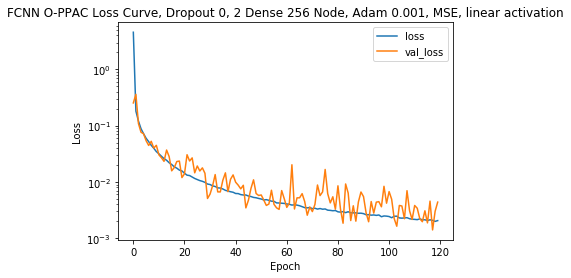

2117/2117 - 6s - loss: 0.0096 - mae: 0.0509 - mse: 0.0096


In [19]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [14]:
#separates x and y predicted values so there can be separate graphs for each
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = test_labels[0]
y_test1 = test_labels[1]

#converts to np.arrays for graphing
x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test[0]
y_test[0]

-8.0

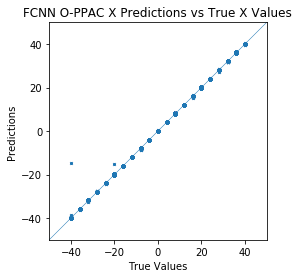

In [15]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

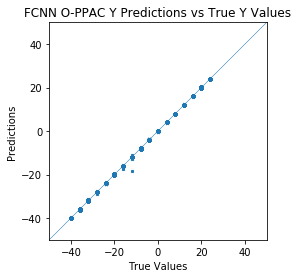

In [16]:
#graph showing the accuracy of FCNN model by comparing predicted and true y values
#should be as close to the diagonal as possible
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [17]:
#to find the locations of largest error within my predicted x values
x_error = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)

4
[25.36715602874756, 4.670292854309082, 1.4720611572265625, 1.0841751098632812]


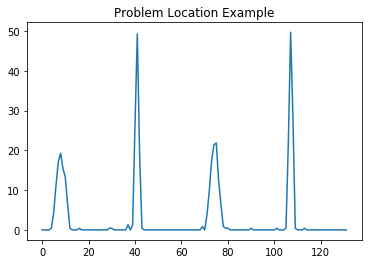

[117]


In [20]:
#graph the location of areas with larger x-error; uses unshuffled data from above
bad_xvalue = 25.36715602874756
x_test_locat = x_error.index(bad_xvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[x_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_xvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_xvalue)])))

print(np.intersect1d(x_locat, y_locat))

In [21]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

3
[-1.062234878540039, -1.3788795471191406, -6.432157516479492]


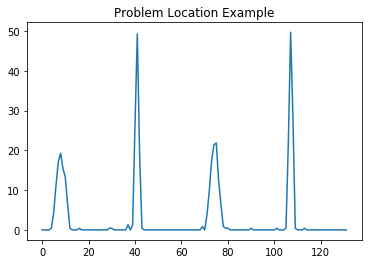

[117]


In [22]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue = -6.432157516479492
y_test_locat = y_error.index(bad_yvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[y_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_yvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_yvalue)])))

print(np.intersect1d(x_locat, y_locat))

67724


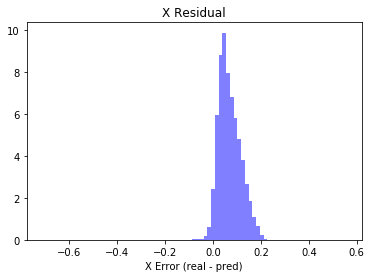

In [23]:
#residue plot of x-error from the FCNN model
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if abs(i) <= 1]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()

67725


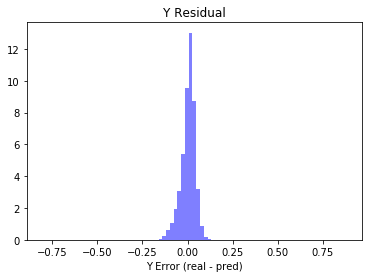

In [24]:
#residue plot of y-error from the FCNN model
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

error_list_y = [i for i in y_error if abs(i) <= 1]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')
plt.title(r'Y Residual')
plt.show()

In [ ]:
#now to look at the data via the Gaussian model to check for better accuracy

In [9]:
#turn the test_data and test_labels dfs into arrays  to work with them easily
test_data_arr = test_data.to_numpy()
test_labels_arr = test_labels.to_numpy()

#separate the test data as done above; used so that it is the same sample as the FCNN
x1_data_test = (test_data_arr[: , :33])*100
x2_data_test = (test_data_arr[:, 33:66])*100
y1_data_test = (test_data_arr[:, 66:99])*100
y2_data_test = (test_data_arr[:, 99:132])*100

#labels kept so they have the same indices
x_label_test = test_labels_arr[ : , 0 ]
y_label_test = test_labels_arr[ : , 1 ]

print(x1_data_test.shape)
print(x_label_test.shape)

print(np.min(x1_data_test))

(67728, 33)
(67728,)
0.0


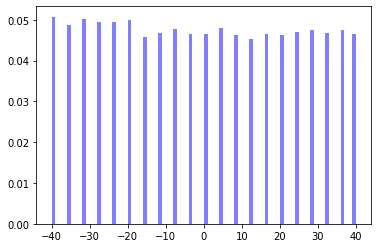

67728


In [10]:
num_bins_x = 80
# the histogram of the data
n, bins, patches = plt.hist(x_label_test, num_bins_x, density=1, facecolor='blue', alpha=0.5)

#plt.xlabel('X Error (real - pred)')
#plt.title(r'X Residual')
plt.show()

print(len(x_label_test))

In [10]:
#https://stackoverflow.com/questions/19206332/gaussian-fit-for-python

In [15]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 34672
x = np.arange(0,33,1)
y = x1_data_test[index,:]

print(y)

#the true location of the peak as given by the label for that event
x_peak_value = ((x_label_test[index]+48)/100)*33

[ 0.          0.          0.          0.          0.          0.40773216
  0.          0.          0.          0.          0.          0.
  0.          0.40773216  5.70825019 23.24073292 36.69589408 29.35671526
  4.89278588  0.40773216  0.          0.40773216  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


In [16]:
#gaussian fit function
def gaussianpdf(x, k, sigma, mu):
    return k*np.exp(-(x-mu)**2/(2*sigma**2))

In [17]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y) > 20:
    kvalue = np.max(y)+(np.max(y)/2)
else:
    kvalue = np.max(y)

popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
print(popt[2])
print(x_peak_value)

16.101410765604395
15.84


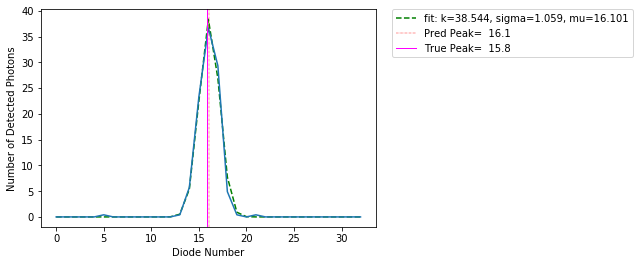

In [18]:
#plotting gaussian to make sure it looks logically correct
plt.plot(x, gaussianpdf(x, *popt), 'g--', label='fit: k=%5.3f, sigma=%5.3f, mu=%5.3f' % tuple(popt))
plt.plot(x1_data_test[index,:])
plt.axvline(x = popt[2], color = "red", linewidth=.4, linestyle='dashdot', label='Pred Peak= %5.1f' %popt[2])
plt.axvline(x = x_peak_value, color = "magenta", linewidth=1, label='True Peak= %5.1f' % x_peak_value)
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [19]:
#function to (hopefully) fit gaussians (and thus, centroids which is what we want) onto all data sets
def centroidmm(x, y):
    try:
        if np.max(y) > 20:
            kvalue = np.max(y)+(np.max(y)/2)
        else:
            kvalue = np.max(y)
        popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,7., 33.]))
        return (popt[2]/33)*100-48 #converts location from diode number to mm (measurement of x_pos & y_pos)
    except RuntimeError:
        return -5555

#function to (hopefully) fit gaussians (and thus, centroids which is what we want) onto all data sets
def centroiddn(x, y):
    try:
        if np.max(y) > 20:
            kvalue = np.max(y)+(np.max(y)/2)
        else:
            kvalue = np.max(y)
        popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,7., 33.]))
        return popt[2]
    except RuntimeError:
        return -5555

In [22]:
print(x1_data_test[1])

[ 0.          0.          0.          0.          0.          0.
  0.43818786  0.          0.          0.          0.43818786  0.43818786
  3.06731503 16.21295088 18.84207805 26.72945955 15.77476301 10.51650868
  1.31456358  0.87637572  0.          0.          0.          0.
  0.          0.43818786  0.          0.43818786  0.          0.
  0.          0.          0.        ]


In [23]:
#DO NOT RERUN UNLESS THE NEURAL NETWORK DATA IS RESHUFFLED; TAKES A VERY LONG TIME
#conversion and calculation + creation of centroid location array for all of the side x1    
x1_peaks = []
for i in range(x1_data_test.shape[0]):
    x1_dn = centroiddn(np.arange(0,33,1), x1_data_test[i,:])
    x1_peaks.append(x1_dn)
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


In [24]:
x1_peaks = np.array(x1_peaks)
np.save("x1_peaks_file_5", x1_peaks)

In [33]:
x1_peaks = []
for i in range(25):
    x1_dn = centroiddn(np.arange(0,33,1), x1_data_test[i,:])
    x1_peaks.append(x2_dn)
    #if i%1000==0:
        #print(i)

In [34]:
x1_peaks = np.array(x1_peaks)
np.save("x1_peaks_file_VERY_SMALL", x1_peaks)

In [31]:
x2_peaks = []
for i in range(25):
    x2_dn = centroiddn(np.arange(0,33,1), x2_data_test[i,:])
    x2_peaks.append(x2_dn)
    #if i%1000==0:
        #print(i)

In [32]:
x2_peaks = np.array(x2_peaks)
np.save("x2_peaks_file_VERY_SMALL", x2_peaks)

In [25]:
#DO NOT RERUN UNLESS THE NEURAL NETWORK DATA IS RESHUFFLED; TAKES A VERY LONG TIME
x2_peaks = []
for i in range(x2_data_test.shape[0]):
    x2_dn = centroiddn(np.arange(0,33,1), x2_data_test[i,:])
    x2_peaks.append(x2_dn)
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


In [26]:
x2_peaks = np.array(x2_peaks)
np.save("x2_peaks_file_5", x2_peaks)

In [27]:
#DO NOT RERUN UNLESS THE NEURAL NETWORK DATA IS RESHUFFLED; TAKES A VERY LONG TIME
y1_peaks = []
for i in range(y1_data_test.shape[0]):
    y1_dn = centroiddn(np.arange(0,33,1), y1_data_test[i,:])
    y1_peaks.append(y1_dn)
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


In [28]:
y1_peaks = np.array(y1_peaks)
np.save("y1_peaks_file_5", y1_peaks)

In [29]:
#DO NOT RERUN UNLESS THE NEURAL NETWORK DATA IS RESHUFFLED; TAKES A VERY LONG TIME
y2_peaks = []
for i in range(x1_data_test.shape[0]):
    y2_dn = centroiddn(np.arange(0,33,1), y2_data_test[i,:])
    y2_peaks.append(y2_dn)
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


In [30]:
y2_peaks = np.array(y2_peaks)
np.save("y2_peaks_file_5", y2_peaks)

In [ ]:
#this data used in different notebook so I wouldn't risk infinitely running code which needs to be stopped
#in notebook "Gaussian Fit Data"